# Scorecast

1. Limpieza  de datos y creacion de nuevas variables.



In [ ]:
#importar libreria optuna
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


In [ ]:
#importar librerias

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importar datos

df = pd.read_excel("DataTFM2.xlsx").sort_values(by=["Team","season","Round","Date"]).reset_index(drop=True)

In [ ]:
# crear columna con variables acumuladas historicamente (score y points)

df["Team_Hist_goalsD"] = df.groupby('Team')['Team_Score'].cumsum()
df["Team_Hist_goals"] = df["Team_Hist_goalsD"].shift(1)
df["Team_Hist_pointsD"] = df.groupby('Team')['Team_Points'].cumsum()
df["Team_Hist_points"] = df["Team_Hist_pointsD"].shift(1)

In [ ]:
# Crear columnas para resultados del local en fechas anteriores (variables rezagadas)

df['Team_Points(T-1)'] = df.groupby('Team')['Team_Points'].shift(1)
df['Team_Points(T-2)'] = df.groupby('Team')['Team_Points'].shift(2)
df['Team_Points(T-3)'] = df.groupby('Team')['Team_Points'].shift(3)
df['Team_Points(T-4)'] = df.groupby('Team')['Team_Points'].shift(4)
df['Team_Points(T-5)'] = df.groupby('Team')['Team_Points'].shift(5)

In [ ]:
# La data esta duplicada en home y away siendo esos campos el mismo partido pero enfoque contrario

dfaway = df[df["Location"]=="Away"].reset_index(drop=True)
dfhome = df[df["Location"]=="Home"].sort_values(by=["Opponent","season","Round"]).reset_index(drop=True)

In [ ]:
# Crear columnas para resultados del oponente en fechas anteriores (variables rezagadas)

dfhome['Opp_Points(T-1)'] = dfaway['Team_Points(T-1)']
dfhome['Opp_Points(T-2)'] = dfaway['Team_Points(T-2)']
dfhome['Opp_Points(T-3)'] = dfaway['Team_Points(T-3)']
dfhome['Opp_Points(T-4)'] = dfaway['Team_Points(T-4)']
dfhome['Opp_Points(T-5)'] = dfaway['Team_Points(T-5)']
dfhome["Opp_Hist_goals"] = dfaway["Team_Hist_goals"]
dfhome["Opp_Hist_points"] = dfaway["Team_Hist_points"]

In [ ]:
#Creando el nuevo set con todas las variables nuevas y reorganizando por fecha y ronda

newdf = dfhome.sort_values(by=["Date","Round"]).reset_index(drop=True)
# descartando variables que que no se usaran.
col_eliminar = ["Time","Date", "Location","Opponent_Points","Country","Competition","Team_Score","Opponent_Score"]
newdf.drop(col_eliminar, axis=1,inplace=True)
# Renombrar variables
newnames = {"Team_Points": "Result", "team_accum_points":"Team_accum_points","opp_accum_goals":"Opp_accum_goals","opp_accum_points":"Opp_accum_points","season":"Season"}
newdf.rename(columns=newnames, inplace=True)

In [ ]:
# Creando nueva variable de goles promedio por temporada

newdf["Team_avg_goals"] = newdf["Team_accum_goals"] / newdf["Round"]
newdf["Opp_avg_goals"] = newdf["Opp_accum_goals"] / newdf["Round"]

In [ ]:
# Nuevo orden de columnas y eliminar filas con datos vacios.

nuevo_orden_columnas = ['Round', 'Team', 'Team_accum_goals',"Team_avg_goals","Team_Hist_goals","Team_accum_goals_conceded", 'Team_accum_points',"Team_Hist_points", 'Opponent',
                         'Opp_accum_goals',"Opp_avg_goals","Opp_Hist_goals","opp_accum_goals_conceded", 'Opp_accum_points',"Opp_Hist_points",
                        'Season', 'Team_Points(T-1)', 'Team_Points(T-2)', 'Team_Points(T-3)',
                        'Team_Points(T-4)', 'Team_Points(T-5)', 'Opp_Points(T-1)',
                        'Opp_Points(T-2)', 'Opp_Points(T-3)', 'Opp_Points(T-4)',
                        'Opp_Points(T-5)', 'Result']
newdf=newdf.reindex(columns=nuevo_orden_columnas).dropna()
newdf.dropna()
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7635 entries, 50 to 7787
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Round                      7635 non-null   int64  
 1   Team                       7635 non-null   object 
 2   Team_accum_goals           7635 non-null   int64  
 3   Team_avg_goals             7635 non-null   float64
 4   Team_Hist_goals            7635 non-null   float64
 5   Team_accum_goals_conceded  7635 non-null   int64  
 6   Team_accum_points          7635 non-null   int64  
 7   Team_Hist_points           7635 non-null   float64
 8   Opponent                   7635 non-null   object 
 9   Opp_accum_goals            7635 non-null   int64  
 10  Opp_avg_goals              7635 non-null   float64
 11  Opp_Hist_goals             7635 non-null   float64
 12  opp_accum_goals_conceded   7635 non-null   int64  
 13  Opp_accum_points           7635 non-null   int6

2. Segmentacion de variables y definicion de sets de entrenamiento y prueba.

In [ ]:
# Defino variables dependientes e independientes

x = newdf[['Round', 'Team', 'Team_accum_goals',"Team_avg_goals","Team_Hist_goals","Team_accum_goals_conceded", 'Team_accum_points',"Team_Hist_points", 'Opponent',
                         'Opp_accum_goals',"Opp_avg_goals","Opp_Hist_goals","opp_accum_goals_conceded", 'Opp_accum_points',"Opp_Hist_points",
                        'Season', 'Team_Points(T-1)', 'Team_Points(T-2)', 'Team_Points(T-3)',
                        'Team_Points(T-4)', 'Team_Points(T-5)', 'Opp_Points(T-1)',
                        'Opp_Points(T-2)', 'Opp_Points(T-3)', 'Opp_Points(T-4)',
                        'Opp_Points(T-5)']]
x =pd.get_dummies(x)
y = newdf["Result"]

In [ ]:
# Divido los datos en conjuntos de entrenamiento y prueba

xtrain, xtest  = x.iloc[:7100] , x.iloc[7100:7570]
ytrain, ytest = y.iloc[:7100] , y.iloc[7100:7570]

# Modelos de prediccion Multiclase.

In [ ]:
# OPCION 1 Regresion logistica:

# Creo el modelo de regresión logística multinomial
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',penalty=None)
model.fit(xtrain, ytrain)

# Realiza predicciones en conjunto de prueba
y_pred = model.predict(xtest)

# Se calcula la precisión del modelo comparando las predicciones con los valores reales.
accuracy = accuracy_score(ytest, y_pred)

print(f'La precisión del modelo es: {accuracy}')

La precisión del modelo es: 0.5276595744680851


In [ ]:
# Opcion 2: GradienboostinClassifier

resultsGBCM= []
for depth in list(range(1, 10)):
   for estimators in list(range(1, 100)):
      model = GradientBoostingClassifier(n_estimators = estimators, max_depth = depth).fit(xtrain,ytrain)
      predicGBCM = model.predict(xtest)
      accuracy = accuracy_score(ytest, predicGBCM)
      resultsGBCM.append({"depth":depth,"n_estimators":estimators, "accuracy":accuracy})
bestGBCM = max(resultsGBCM, key=lambda x: x['accuracy'])
print("MEJORES PARAMETROS: ",bestGBCM)

NameError: name 'xtrain' is not defined

In [ ]:
# Opcion 2: GradienboostinClassifier con Optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 250)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)
    score = cross_val_score(model, xtrain, ytrain, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params_optunaGBC = study.best_params
print("MEJORES PARAMETROS: ", best_params_optunaGBC)

[I 2024-03-06 19:31:16,981] A new study created in memory with name: no-name-107a54e9-4252-45a9-bcb5-4e5a77ad88cd
[I 2024-03-06 19:31:20,985] Trial 0 finished with value: 0.4122535211267605 and parameters: {'n_estimators': 5, 'max_depth': 5}. Best is trial 0 with value: 0.4122535211267605.
[I 2024-03-06 19:31:22,703] Trial 1 finished with value: 0.47169014084507044 and parameters: {'n_estimators': 2, 'max_depth': 4}. Best is trial 1 with value: 0.47169014084507044.
[I 2024-03-06 19:31:23,679] Trial 2 finished with value: 0.4271830985915493 and parameters: {'n_estimators': 4, 'max_depth': 1}. Best is trial 1 with value: 0.47169014084507044.
[I 2024-03-06 19:31:24,582] Trial 3 finished with value: 0.4711267605633802 and parameters: {'n_estimators': 2, 'max_depth': 3}. Best is trial 1 with value: 0.47169014084507044.
[I 2024-03-06 19:31:27,284] Trial 4 finished with value: 0.4097183098591549 and parameters: {'n_estimators': 4, 'max_depth': 5}. Best is trial 1 with value: 0.471690140845070

MEJORES PARAMETROS:  {'n_estimators': 2, 'max_depth': 4}


In [ ]:
# OPCION 3: Random Forest: es un método de ensamble que utiliza múltiples árboles de decisión para mejorar la precisión de la clasificación.

resultsRFC= []
for depth in list(range(1, 10)):
  for estimators in list(range(1, 100)):
    model = RandomForestClassifier(n_estimators=estimators, random_state=42).fit(xtrain, ytrain)
    predicRFC = model.predict(xtest)
    accuracy = accuracy_score(ytest, predicRFC)
    resultsRFC.append({"n_estimators":estimators, "accuracy":accuracy})

bestRFC = max(resultsRFC, key=lambda x: x['accuracy'])
print("MEJORES PARAMETROS: ",bestRFC)

MEJORES PARAMETROS:  {'n_estimators': 42, 'accuracy': 0.5276595744680851}


In [ ]:
#OPCION 4 # :Maquina de soporte de Vectores = Support Vector Machines (SVM): SVM sirve para tareas de clasifcacion y regresion.

# Creo el modelo SVM
model = SVC(kernel = 'rbf',random_state = 42).fit(xtrain, ytrain)
predSMV = model.predict(xtest)

# Calculo el accuracy
accuracy = accuracy_score(ytest, predSMV)

print(f'Precisión del modelo: {accuracy}')

Precisión del modelo: 0.5297872340425532


In [ ]:
# OPCION 5: K-Nearest Neighbors (KNN): KNN es un algoritmo simple y efectivo que clasifica una observación basándose en las observaciones más cercanas a ella en el espacio de características.

resultsKNC= []
for neighbors in list(range(1, 100)):
  model = KNeighborsClassifier(n_neighbors=neighbors).fit(xtrain, ytrain)
  predicKNC = model.predict(xtest)
  accuracy = accuracy_score(ytest, predicKNC)
  resultsKNC.append({"n_estimators":neighbors, "accuracy":accuracy})

bestKNC = max(resultsKNC, key=lambda x: x['accuracy'])
print("MEJORES PARAMETROS: ",bestKNC)

MEJORES PARAMETROS:  {'n_estimators': 12, 'accuracy': 0.5446808510638298}


# Modelos de prediccion Binaria.

In [ ]:
# Binarizo el resultado  de la variable independiente "Result" del nuevo dataframe dònde pérdida(o) y empate (1) son igual a 0,  y victoria(3) =1
yb = y.replace({0: 0, 1: 0, 3:1})

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento

X_train, X_test = x.iloc[:7100] , x.iloc[7100:7570]
y_train, y_test = yb.iloc[:7100], yb.iloc[7100:7570]

In [ ]:
# 1 -  Regresión logística Binaria.

model = LogisticRegression(penalty='none', solver='lbfgs')                        #‘lbfgs’ se utiliza para encontrar los mejores parámetros
model.fit(X_train, y_train)                                                       #(o coeficientes) que hacen el modelo sea lo más preciso posible sin penalización
y_predRGB = model.predict(X_test)

accuracy = accuracy_score(y_test, y_predRGB)

print("Presición del modelo :", accuracy)
auc = roc_auc_score(y_test, y_predRGB)

print("AUC:", auc)

Presición del modelo : 0.6702127659574468
AUC: 0.6645625366999414


In [ ]:
# TEST ■ 2 - Random Forest Utilizando varios hiperparámetros + AUC

resultsRFCB = []

for estimators in list(range(1, 50)):
    for max_depth in list(range(1, 50)):
        clf = RandomForestClassifier(n_estimators=estimators, max_depth=max_depth, random_state=42)
        clf.fit(X_train, y_train)
        y_predRFC = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_predRFC)
        auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] )
        resultsRFCB.append({"n_estimators": estimators, "max_depth": max_depth, "accuracy": accuracy, "auc": auc})

bestRFCB = max(resultsRFCB, key=lambda x: x['accuracy'])
print("MEJORES PARAMETROS: ", bestRFCB)

MEJORES PARAMETROS:  {'n_estimators': 15, 'max_depth': 6, 'accuracy': 0.6829787234042554, 'auc': 0.7052994715208456}


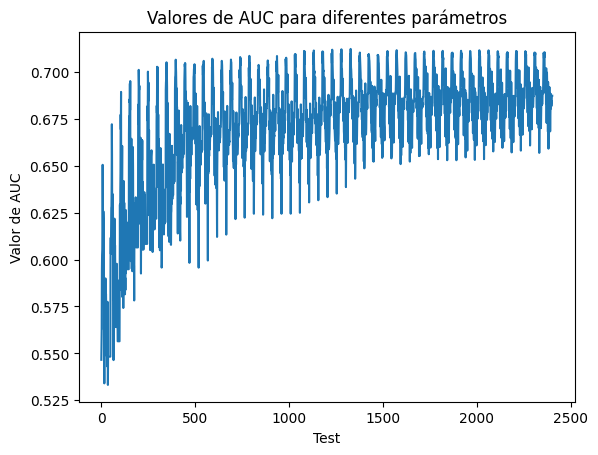

In [ ]:
# TEST ■ 2Grafico AUC Random Forest

auc_values = [result['auc'] for result in resultsRFCB]     # Extraemos los valores de AUC de los resultados
fig, ax = plt.subplots()                                    # Creamos una figura y un eje
ax.plot(list(range(1, len(auc_values) + 1)), auc_values)   # Graficamos los valores de AUC
ax.set_title('Valores de AUC para diferentes parámetros')   # Establecemos el título y las etiquetas
ax.set_xlabel('Test')
ax.set_ylabel('Valor de AUC')
plt.show()

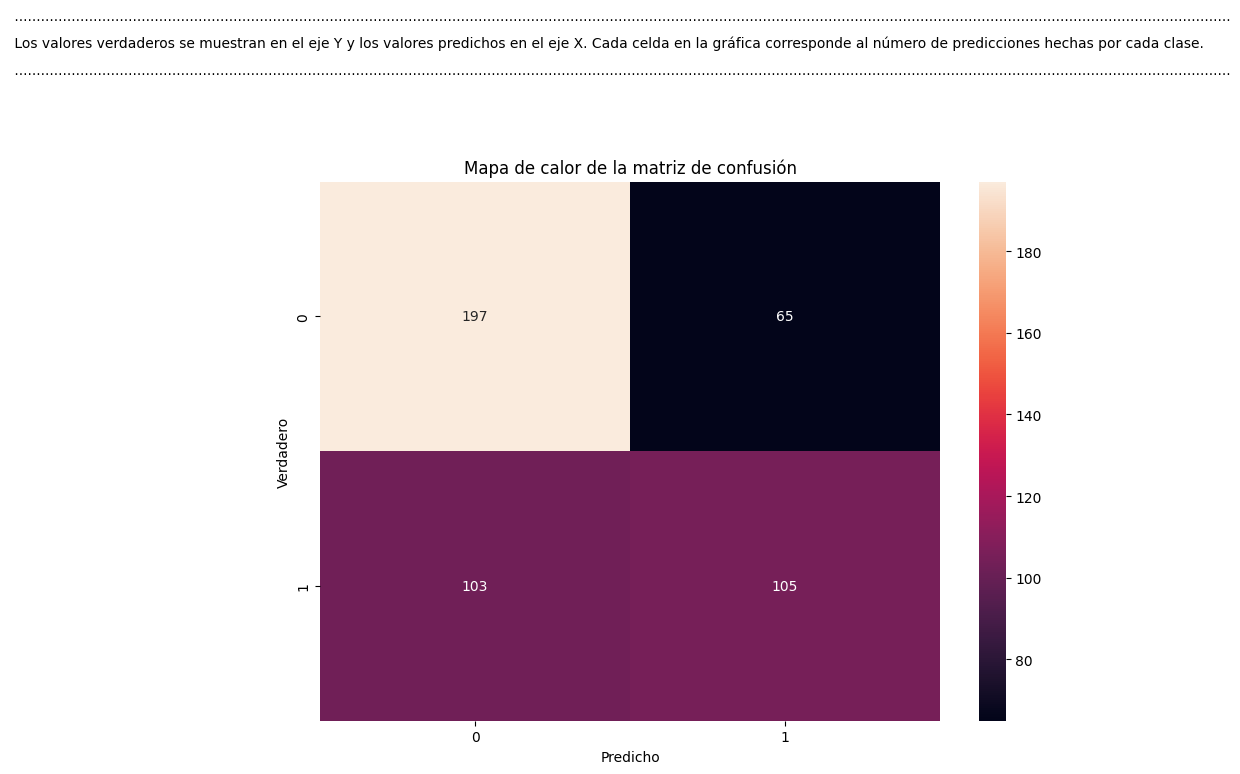

In [ ]:
# TEST ■ 2Grafico MAtriz de confusión  Random Forest

matriz = confusion_matrix(y_test, y_predRFC)

# Visualizamos la matriz de confusión usando un mapa de calor de seaborn
plt.figure(figsize=(10,7))
sns.heatmap(matriz, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# configuramos etiquetas y textos
plt.title('Mapa de calor de la matriz de confusión')
plt.text(-1, -0.6, ' ......................................................................................................................................................................................................................................................................................', ha='left')
plt.text(-1, -0.5, ' Los valores verdaderos se muestran en el eje Y y los valores predichos en el eje X. Cada celda en la gráfica corresponde al número de predicciones hechas por cada clase.', ha='left')
plt.text(-1, -0.4, ' ......................................................................................................................................................................................................................................................................................', ha='left')
plt.show()


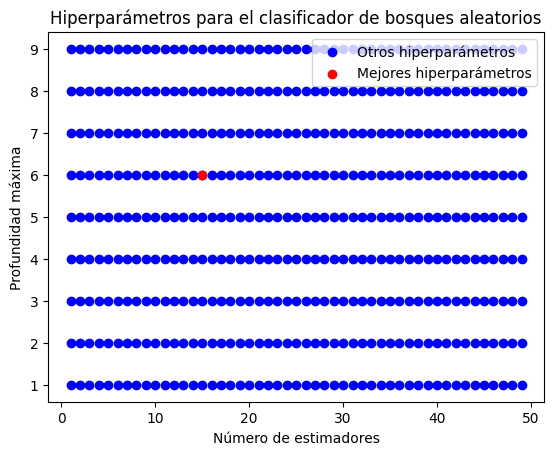

In [ ]:

# Convertir los resultados en un DataFrame
df = pd.DataFrame(resultsRFCB)

# Encontrar la fila con la mejor precisión
best_row = df[df['accuracy'] == df['accuracy'].max()]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Dibujar todos los hiperparámetros como puntos azules
ax.scatter(df['n_estimators'], df['max_depth'], color='blue', label='Otros hiperparámetros')

# Dibujar los mejores hiperparámetros como un punto rojo
ax.scatter(best_row['n_estimators'], best_row['max_depth'], color='red', label='Mejores hiperparámetros')

# Añadir etiquetas a los ejes y un título
ax.set_xlabel('Número de estimadores')
ax.set_ylabel('Profundidad máxima')
ax.set_title('Hiperparámetros para el clasificador de bosques aleatorios')
ax.legend()
plt.show()

In [ ]:
# ■ 3 - K-Nearest Neighbors (KNN) CON OPTUNA

def objetivo_k(trial):                                                           # Definimos la función objetivo para la optimización
    n_neighbors = trial.suggest_int('n_neighbors', 1, 150)                      # Definimos los rangos de los hiperparámetros
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)                         # Creamos el clasificador kNN con el número de vecinos actual
    clf.fit(X_train, y_train)                                                   # Entrenamos el modelo usando el conjunto de entrenamiento
    y_pred = clf.predict(X_test)                                                # Realizamos predicciones en el conjunto de prueba
    accuracy = accuracy_score(y_test, y_pred)                                   # Calculamos la precisión del modelo
    return accuracy                                                             # Devuelve la precisión como una medida de la calidad del modelo

study = optuna.create_study(direction='maximize')                               # Creamos un estudio de Optuna y optimiza los hiperparámetros
study.optimize(objetivo_k, n_trials=100)
print("MEJORES PARAMETROS: ", study.best_params)                                # Mostramos los mejores hiperparámetros
print("MEJOR PRECISIÓN: ", study.best_value)

[I 2024-03-03 18:03:53,748] A new study created in memory with name: no-name-1f8ebb76-4d92-4161-bb27-f97a453f911a
[I 2024-03-03 18:03:54,029] Trial 0 finished with value: 0.6851063829787234 and parameters: {'n_neighbors': 143}. Best is trial 0 with value: 0.6851063829787234.
[I 2024-03-03 18:03:54,317] Trial 1 finished with value: 0.6787234042553192 and parameters: {'n_neighbors': 100}. Best is trial 0 with value: 0.6851063829787234.
[I 2024-03-03 18:03:54,524] Trial 2 finished with value: 0.6808510638297872 and parameters: {'n_neighbors': 69}. Best is trial 0 with value: 0.6851063829787234.
[I 2024-03-03 18:03:54,676] Trial 3 finished with value: 0.6851063829787234 and parameters: {'n_neighbors': 131}. Best is trial 0 with value: 0.6851063829787234.
[I 2024-03-03 18:03:54,812] Trial 4 finished with value: 0.6787234042553192 and parameters: {'n_neighbors': 100}. Best is trial 0 with value: 0.6851063829787234.
[I 2024-03-03 18:03:54,929] Trial 5 finished with value: 0.6702127659574468 a

MEJORES PARAMETROS:  {'n_neighbors': 16}
MEJOR PRECISIÓN:  0.6914893617021277


In [ ]:
study.best_params
import matplotlib.pyplot as plt
optuna.visualization.plot_optimization_history(study)

In [ ]:
# ■ 4 - Maquina de soporte de Vectores (SVM)

clf = SVC(kernel='linear')                                  # Utiliza un hiperplano lineal para separar los datos.
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

Precisión del modelo: 0.6787234042553192


In [ ]:
# ■ 5 - XG BOOST Evaluando varios hiperparámetros

max_depths = [2, 4, 6, 8, 10]
learning_rates = [0.01, 0.1, 0.2, 0.3]
n_estimators = [50, 100, 150, 200]

resultsXGB = []
for max_depth in max_depths:
    for learning_rate in learning_rates:
        for n_estimator in n_estimators:
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimator)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            resultsXGB.append({"max_depth": max_depth, "learning_rate": learning_rate, "n_estimators": n_estimator, "accuracy": accuracy})

bestXGB = max(resultsXGB, key=lambda x: x['accuracy'])
print("MEJORES PARAMETROS: ", bestXGB)

MEJORES PARAMETROS:  {'max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 100, 'accuracy': 0.674468085106383}


In [ ]:
# ■ 6 -  Gradient Boosting Classifier Binario

resultsGBC = []
for depth in list(range(1, 8)):
    for estimators in list(range(1, 100)):

        clf = GradientBoostingClassifier(n_estimators=estimators, max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        resultsGBC.append({"depth": depth, "n_estimators": estimators, "accuracy": accuracy})

bestGBC = max(resultsGBC, key=lambda x: x['accuracy'])
print("MEJORES PARAMETROS: ", bestGBC)

# Buisiness Case

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba 85% 6450

# Entrenamiento
X_train = x.iloc[:6466]
y_train = yb.iloc[:6466]
X_test = x.iloc[6466:7607]
y_test = yb.iloc[6466:7607]

# Reentreno  2
X_train2 = x.iloc[:7607]
y_train2 = yb.iloc[:7607]
X_bc2 = x.iloc[7607:7614]
y_bc2 = yb.iloc[7607:7614]

# Reentreno  3
X_train3 = x.iloc[:7614]
y_train3 = yb.iloc[:7614]
X_bc3 = x.iloc[7614:7621]
y_bc3 = yb.iloc[7614:7621]

# Reentreno  4
X_train4 = x.iloc[:7621]
y_train4 = yb.iloc[:7621]
X_bc4 = x.iloc[7621:7628]
y_bc4 = yb.iloc[7621:7628]

# Reentreno  5
X_train5 = x.iloc[:7628]
y_train5 = yb.iloc[:7628]
X_bc5 = x.iloc[7628:]
y_bc5 = yb.iloc[7628:]

Aplicacion Modelos Binarios

In [ ]:
# ■  - RandomForest

# ■ enreno primera vuelta
clf = RandomForestClassifier(n_estimators=120, max_depth=9, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)                                                            # ■ realizo predicciones
print("Precisión del modelo:", accuracy_score(y_test, y_pred))                          # ■ Evalua modelo

Precisión del modelo: 0.6608238387379491


In [ ]:
# ■ Reentreno 2

clf.fit(X_train2, y_train2)                                                             # ■ Reentreno modelo
y_pred2 = clf.predict(X_bc2)                                                          # ■  Realiza las predicciones con los nuevos datos
print("Precisión del modelo después de reentrenar:", accuracy_score(y_bc2, y_pred2))  # ■  Evalua modelo con Datos

Precisión del modelo después de reentrenar: 0.5714285714285714


In [ ]:
# ■ Reentreno 3

clf.fit(X_train3, y_train3)                                                             # ■ Reentreno modelo
y_pred3 = clf.predict(X_bc3)                                                          # ■  Realiza las predicciones con los nuevos datos
print("Precisión del modelo después de reentrenar:", accuracy_score(y_bc3, y_pred3))  # ■  Evalua modelo con Datos

Precisión del modelo después de reentrenar: 0.7142857142857143


In [ ]:
# ■ Reentreno 4

clf.fit(X_train4, y_train4)                                                             # ■ Reentreno modelo
y_pred4 = clf.predict(X_bc4)                                                          # ■  Realiza las predicciones con los nuevos datos
print("Precisión del modelo después de reentrenar:", accuracy_score(y_bc4, y_pred4))  # ■  Evalua modelo con Datos

Precisión del modelo después de reentrenar: 0.7142857142857143


In [ ]:
# ■ Reentreno 5
clf.fit(X_train5, y_train5)                                                             # ■ Reentreno modelo
y_pred5 = clf.predict(X_bc5)                                                          # ■  Realiza las predicciones con los nuevos datos
print("Precisión del modelo después de reentrenar:", accuracy_score(y_bc5, y_pred5))   # ■  Evalua modelo con Datos

Precisión del modelo después de reentrenar: 0.42857142857142855


In [ ]:
# Imprimiendo resultados de prediccion vs real de Random Forest

df1 = pd.DataFrame(y_pred2)
df2 = pd.DataFrame(y_pred3)
df3 = pd.DataFrame(y_pred4)
df4 = pd.DataFrame(y_pred5)
ResultadosRF = pd.concat([df1, df2, df3, df4],ignore_index=True)
ResultadosRF.rename(columns={0:"Predict"}, inplace=True)
ResultadosRF["Final"] = pd.concat([y_bc2, y_bc3, y_bc4, y_bc5],ignore_index=True)
ResultadosRF.to_excel("BCRFB.xlsx")

In [ ]:
# ■  - XG BOOST

# ■ Entreno primera vuelta
model = XGBClassifier(use_label_encoder=False, n_estimators=187, max_depth=8, learning_rate=0.0369984949752035)
model.fit(X_train, y_train)
y_predxg = model.predict(X_test)                                                # ■ realizo predicciones
accuracy = accuracy_score(y_test, y_predxg)                                       # ■ Evalúa el modelo
print(f'Precisión del modelo: {accuracy}')                                      # ■ Evalua modelo

Precisión del modelo: 0.6441717791411042


In [ ]:
# ■ Reentreno 2

model.fit(X_train2, y_train2)                                                   # ■ Reentreno modelo
y_predxg2 = model.predict(X_bc2)                                                # ■  Realiza las predicciones con los nuevos datos
accuracy2 = accuracy_score(y_bc2, y_predxg2)                                    # ■  Evalua modelo con Datos
print(f'Precisión del modelo después de reentrenar: {accuracy2}')

Precisión del modelo después de reentrenar: 0.7142857142857143


In [ ]:
# ■ Reentreno 3

model.fit(X_train3, y_train3)                                                   # ■ Reentreno modelo
y_predxg3 = model.predict(X_bc3)                                                # ■  Realiza las predicciones con los nuevos datos
accuracy3 = accuracy_score(y_bc3, y_predxg3)                                    # ■  Evalua modelo con Datos
print(f'Precisión del modelo después de reentrenar: {accuracy3}')

Precisión del modelo después de reentrenar: 0.7142857142857143


In [ ]:
# ■ Reentreno 4

model.fit(X_train4, y_train4)                                                   # ■ Reentreno modelo
y_predxg4 = model.predict(X_bc4)                                                # ■  Realiza las predicciones con los nuevos datos
accuracy4 = accuracy_score(y_bc4, y_predxg4)                                    # ■  Evalua modelo con Datos
print(f'Precisión del modelo después de reentrenar: {accuracy4}')

Precisión del modelo después de reentrenar: 0.7142857142857143


In [ ]:
# ■ Reentreno 5

model.fit(X_train5, y_train5)                                                   # ■ Reentreno modelo
y_predxg5 = model.predict(X_bc5)                                                # ■  Realiza las predicciones con los nuevos datos
accuracy5 = accuracy_score(y_bc5, y_predxg5)                                    # ■  Evalua modelo con Datos
print(f'Precisión del modelo después de reentrenar: {accuracy5}')

Precisión del modelo después de reentrenar: 0.42857142857142855


In [ ]:
# Imprimiendo resultados de prediccion vs real de XGBoost

df1 = pd.DataFrame(y_predxg2)
df2 = pd.DataFrame(y_predxg3)
df3 = pd.DataFrame(y_predxg4)
df4 = pd.DataFrame(y_predxg5)
Resultadosxg = pd.concat([df1, df2, df3, df4],ignore_index=True)
Resultadosxg.rename(columns={0:"Predict"}, inplace=True)
Resultadosxg["Final"] = pd.concat([y_bc2, y_bc3, y_bc4, y_bc5],ignore_index=True)
Resultadosxg.to_excel("BCXGB.xlsx")

Aplicacion modelos Multiclase

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba 85% 6450

# Entrenamiento
X_train = x.iloc[:6466]
y_train = y.iloc[:6466]
X_test = x.iloc[6466:7607]
y_test = y.iloc[6466:7607]

# Reentreno  2
X_train2 = x.iloc[:7607]
y_train2 = y.iloc[:7607]
X_bc2 = x.iloc[7607:7614]
y_bc2 = y.iloc[7607:7614]

# Reentreno  3
X_train3 = x.iloc[:7614]
y_train3 = y.iloc[:7614]
X_bc3 = x.iloc[7614:7621]
y_bc3 = y.iloc[7614:7621]

# Reentreno  4
X_train4 = x.iloc[:7621]
y_train4 = y.iloc[:7621]
X_bc4 = x.iloc[7621:7628]
y_bc4 = y.iloc[7621:7628]

# Reentreno  5
X_train5 = x.iloc[:7628]
y_train5 = y.iloc[:7628]
X_bc5 = x.iloc[7628:]
y_bc5 = y.iloc[7628:]

In [ ]:
# ■  - K-Neighbors Classifier

# ■ Entreno (primera vuelta)
clfBC = KNeighborsClassifier(n_neighbors=12)
clfBC.fit(X_train, y_train)
pred1 = clfBC.predict(X_test)                                                            # ■ realizo predicciones
print("Precisión del modelo:", accuracy_score(y_test, pred1))                          # ■ Evalua modelo

Precisión del modelo: 0.5030674846625767


In [ ]:
# ■ Reentreno 2
clfBC.fit(X_train2, y_train2)
pred2 = clfBC.predict(X_bc2)                                                            # ■ realizo predicciones
print("Precisión del modelo:", accuracy_score(y_bc2, pred2))

Precisión del modelo: 0.14285714285714285


In [ ]:
# ■ Reentreno 3

clfBC.fit(X_train3, y_train3)
pred3 = clfBC.predict(X_bc3)                                                            # ■ realizo predicciones
print("Precisión del modelo:", accuracy_score(y_bc3, pred3))  # ■  Evalua modelo con Datos 2

Precisión del modelo: 0.7142857142857143


In [ ]:
# ■ Reentreno 4

clfBC.fit(X_train4, y_train4)
pred4 = clfBC.predict(X_bc4)                                                            # ■ realizo predicciones
print("Precisión del modelo:", accuracy_score(y_bc4, pred4))

Precisión del modelo: 0.5714285714285714


In [ ]:
# ■ Reentreno 5

clfBC.fit(X_train5, y_train5)
pred5 = clfBC.predict(X_bc5)                                                            # ■ realizo predicciones
print("Precisión del modelo:", accuracy_score(y_bc5, pred5))

Precisión del modelo: 0.2857142857142857


In [ ]:
# Imprimiendo resultados de K-NC vs real

df1 = pd.DataFrame(pred2)
df2 = pd.DataFrame(pred3)
df3 = pd.DataFrame(pred4)
df4 = pd.DataFrame(pred5)
ResultadosKN = pd.concat([df1, df2, df3, df4],ignore_index=True)
ResultadosKN.rename(columns={0:"Predict"}, inplace=True)
ResultadosKN["Final"] = pd.concat([y_bc2, y_bc3, y_bc4, y_bc5],ignore_index=True)
ResultadosKN.to_excel("BCKNM.xlsx")